In [1]:
### import libraries
import os
import cv2 as cv2
import numpy as np
import json  as json
import imutils
import math
from matplotlib import pyplot as plt

path_dataset = './dataset/bilboards/'

def iread(img_path, resize_width=None):
    img = cv2.imread(path_dataset + img_path)
    if resize_width is not None:
        img = imutils.resize(img, width=resize_width)
    return img

def iinfo(img):
    print("[IMAGE] height: {} x width: {} x channels: {} - data type: {}".format(
        img.shape[0], 
        img.shape[1], 
        (img.shape[2] if img.ndim > 2 else 0),
        img.dtype))

[IMAGE] height: 1080 x width: 1920 x channels: 0 - data type: uint8
[IMAGE] height: 420 x width: 1920 x channels: 0 - data type: uint8


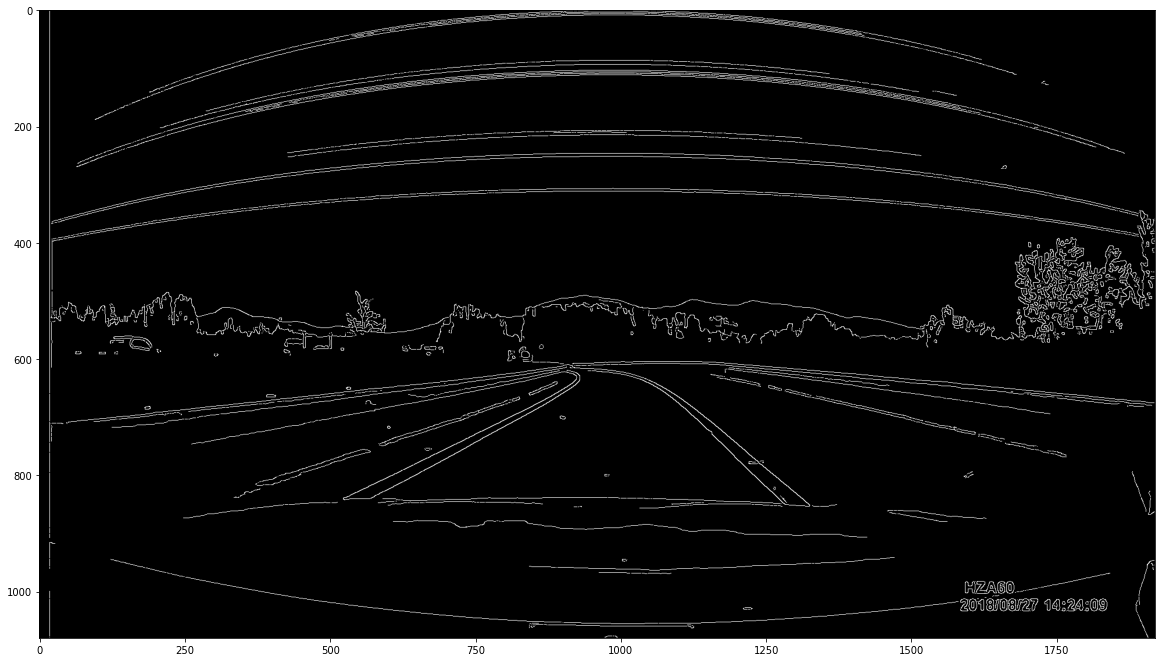

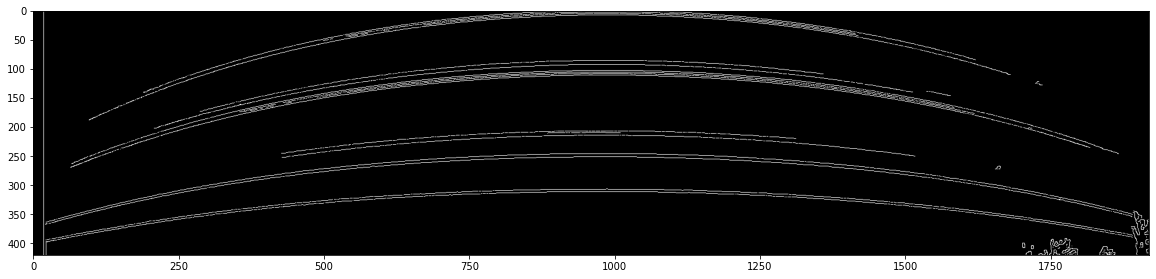

In [2]:
edges_rgb   = iread('dataset_IMG_0249_18_canny.png')
edges_white = cv2.cvtColor(edges_rgb, cv2.COLOR_BGR2GRAY)
edges = cv2.bitwise_not(edges_white)

plt.figure(figsize=(20,20))
plt.imshow(edges, cmap='gray')
iinfo(edges)

roi=edges[0:420, 0:]
plt.figure(figsize=(20, 20))
plt.imshow(roi, cmap='gray')
iinfo(roi)


# Get points

In [3]:
def print_points(pts):
    print("num of points: {}".format(pts.shape))
    plt.figure()
    plt.scatter(pts[:, 0], pts[:, 1])
    plt.title('Input points')

# Get Minimal Set

In [4]:
def get_minimal_set(pts, number_minimal_pts, debug=False):
    this_pts = pts.copy()
    sample_pts = []
    sample_indices = []
    
    for i in range(number_minimal_pts):
        sample_i = np.random.randint(low=0, high=pts.shape[0] - 1)
        sample_indices.append(sample_i)
        sample_pts.append(this_pts[sample_i])
        this_pts = np.delete(this_pts, sample_i, 0)
    # convert to numpy arrays
    sample_pts     = np.array(sample_pts)
    sample_indices = np.array(sample_indices, dtype=int) 
    
    if debug:
        #print("sample set: \n\t{}\n sample_indices:\n\t {}\n new pts shape: \n\t{}".format(sample_pts, sample_indices, this_pts.shape))
        plt.figure(figsize=(10, 10))
        plt.gca().invert_yaxis()
        x = this_pts[:, 0]
        y = this_pts[:, 1]
        plt.plot(x, y, 'r.')
        
        sample_x = sample_pts[:, 0]
        sample_y = sample_pts[:, 1]
        plt.plot(sample_x, sample_y, 'g.')

    return sample_pts, this_pts, sample_indices

def get_parabola_from_set(coords, debug=False):
    x = coords[:, 0]
    y = coords[:, 1]
    parabola = T.fit(x, y, deg=2, full=False)
    
    if debug:
        plt.figure(figsize=(10, 10))
        plt.plot(x, y, 'r.')
    
    x_axis = np.linspace(0, roi.shape[1], roi.shape[1]) # roi dimension
    
    if debug:
        plt.plot(x_axis, parabola(x_axis), 'b')
    return parabola

def get_line_from_set(coords, debug=False):
    x = coords[:, 0]
    y = coords[:, 1]
    
    try:
        line = T.fit(x, y, deg=1, full=False)
    except Exception as e:
        if np.min(x) == np.max(x):
            print ("coords have same x {}".format(coords))
            x = [] + [coords[0][0]] + [coords[0][0] + 0.0001] 
            line = T.fit(x, y, deg=1, full=False)
    
    if debug:
        plt.figure(figsize=(10, 10))
        plt.plot(x, y, 'r.')
    
    x_axis = np.linspace(0, roi.shape[1], roi.shape[1]) # roi dimension
    
    if debug:
        plt.plot(x_axis, line(x_axis), 'b')
    return line


# Get Model

In [8]:
import time
from numpy.polynomial import Chebyshev as T

def get_models_lines(pts, number_models, number_minimal_pts=2, debug=False, step_debug=1000, overwrite=False):
    models = list()
    # time utils
    start_time = time.time()
    step_time = time.time()
    
    for j in range(number_models):

        if len(pts) < number_minimal_pts:
            print('pts finished for sampling')
            break
        
        sample_j, new_pts , _   = get_minimal_set(pts, number_minimal_pts=number_minimal_pts, debug=debug)
        line_j            = get_line_from_set(sample_j, debug=debug) 
        models.append(line_j)

        if overwrite:
            pts = new_pts

        # step time end
        if j % step_debug == 0:
            end_time = time.time()
            elapsed = end_time - step_time
            print("{}] took: {}".format(j, time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
            step_time = time.time()    

    # time utils
    end_time = time.time()
    elapsed = end_time - start_time
    print("===============================================")
    print("Completed! total time: {}".format(time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
    print("===============================================")

    return models
            
            
def get_models_parabola(pts, number_models, number_minimal_pts=2, debug=False, step_debug=1000, overwrite=False):
    models = list()
    # time utils
    start_time = time.time()
    step_time = time.time()
    
    for j in range(number_models):
        if len(pts) < number_minimal_pts:
            print('pts finished for sampling')
            break
        
        sample_j, new_pts , _   = get_minimal_set(pts, number_minimal_pts=number_minimal_pts, debug=debug)
        parabola_j        = get_parabola_from_set(sample_j, debug=debug) 
        models.append(parabola_j)

        if overwrite:
            pts = new_pts

        # step time end
        if j % step_debug == 0:
            end_time = time.time()
            elapsed = end_time - step_time
            print("{}] took: {}".format(j, time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
            step_time = time.time()

    # time utils
    end_time = time.time()
    elapsed = end_time - start_time
    print("===============================================")
    print("Completed! total time: {}".format(time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
    print("===============================================")

    return models    

In [9]:
def print_model(model):
    x_axis = np.linspace(0, roi.shape[1], roi.shape[1]) # roi dimension
    plt.plot(x_axis, model(x_axis), 'b')

def print_model_with_pts(model, pts):
    plt.scatter(pts[:, 0], pts[:, 1])
    x_axis = np.linspace(0, roi.shape[1], roi.shape[1]) # roi dimension
    plt.plot(x_axis, model(x_axis), 'r')

# Calculate Distance

In [10]:
from numpy import polynomial as P

def distance_line_pts(pts, line, thr = roi.shape[0]):
    try:
        x = pts[:, 0]
        y = pts[:, 1]
        q, m = line.convert(kind=P.Polynomial).coef
    except Exception as e:
        print (e)
        q = line.convert(kind=P.Polynomial).coef
        m = 0
    a = -m
    b = 1
    c = -q
    
    d = np.abs((np.multiply(a, x) + np.multiply(b, y) + np.repeat(c, len(x))) / np.sqrt(a**2 + b**2))
    d[d>thr] = np.inf
    return d
    

# Preference Matrix


In [11]:
# Preference matrix utils
import seaborn as sn
import time

def print_preference_space(preference_matrix):
    preference_matrix_new = preference_matrix.copy()
    
    preference_matrix_new[preference_matrix==np.inf] = 0
    preference_matrix_new[preference_matrix<np.inf]  = 1
    
    x, y = preference_matrix_new.nonzero()

    plt.figure(figsize=(10, 10))
    plt.gca().invert_yaxis()
    plt.plot(x, y, 'r.')

def print_preference_matrix(matrix):
    fig, ax = plt.subplots(figsize=(15,15))         
    sn.heatmap(matrix, cmap="binary", yticklabels=False)
    print_preference_space(matrix)

In [12]:
def get_preference_matrix(pts : np.array, models : np.array, thr=roi.shape[0], limit=np.inf, step_debug=50, debug=False):
    
    # time utils
    start_time = time.time()
    
    x = pts[:, 0]
    y = pts[:, 1]
    matrix = np.array([])
    
    step_time = time.time()
    i = 0
    for m in models:
        if i == limit:
            break
        
        if len(matrix) == 0 :
            matrix = distance_line_pts(pts, m)
        else:
            matrix = np.column_stack([matrix, distance_line_pts(pts, m)])
        
        # step time end
        if i % step_debug == 0:
            end_time = time.time()
            elapsed = end_time - step_time
            print("{}] took: {}".format(i, time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
            step_time = time.time()
        i += 1
        
    # time utils
    end_time = time.time()
    elapsed = end_time - start_time
    print("===============================================")
    print("Completed! total time: {}".format(time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
    print("===============================================")
#    matrix[matrix > thr] = 0
    return matrix

def print_matrix_info(matrix):
    mean    = matrix[matrix < np.inf].mean()
    minimum = np.min(matrix[matrix < np.inf])
    maximum = np.max(matrix[matrix < np.inf])
    
    num_inf = np.sum((matrix==np.inf).ravel())
    num_min = np.sum((matrix == minimum).ravel())
    num_max = np.sum((matrix == maximum).ravel())
    
    below_avg = np.sum((matrix < mean).ravel())
    above_avg = np.sum((matrix > mean).ravel()) -  num_inf
    
    print("mean:\t {}".format(mean))
    print("min:\t {}".format(minimum))
    print("max:\t {}".format(maximum))
    print("num of total:\t {}".format(matrix.shape[0]))
    print("num of dropped:\t {}".format(num_inf))
    print("num of minimum:\t {}".format(num_min))
    print("num of maximum:\t {}".format(num_max))
    print("num of < average:\t {}".format(below_avg))
    print("num of > average:\t {}".format(above_avg))
    
def print_model_info_matrix(matrix, model_i):
    col = matrix[:, model_i]
    if len(col) == 0:
        print("{} model] pts: 0 num of min: 0, num of max: 0 min: np.inf, max: np.inf".format(model_i))
        return
    num_pts = np.sum((col < np.inf).ravel())

    mean    = col[col < np.inf].mean()
    minimum = np.min(col[col < np.inf])
    maximum = np.max(col[col < np.inf])
    
    num_min = np.sum((col == minimum).ravel())
    num_max = np.sum((col == maximum).ravel())

    print("{} model] pts: {} num of min: {}, num of max: {} min: {}, max: {}".format(model_i, num_pts, num_min, num_max, minimum, maximum))

def model_num_pts(col):
    return np.sum((col < np.inf).ravel())

def model_top_ten(matrix):
    return np.argsort(np.apply_along_axis(model_num_pts, 0, matrix))[::-1][:10]    

num of points: (5000, 2)


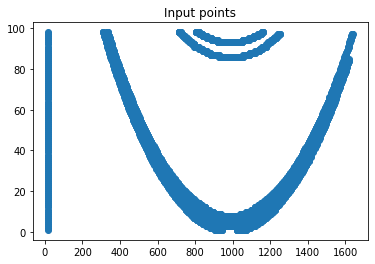

In [13]:
row, col = roi.nonzero()
pts = np.column_stack((col, row)) # this are the points
pts = pts[:5000, :]

print_points(pts)

In [15]:
models = get_models_lines(pts, pts.shape[0] * 10, overwrite=True)

0] took: 00 h 00 m 00 s


/home/fedus/.local/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:299: RuntimeWarning: divide by zero encountered in double_scalars
  off = (old[1]*new[0] - old[0]*new[1])/oldlen
/home/fedus/.local/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:300: RuntimeWarning: divide by zero encountered in true_divide
  scl = newlen/oldlen
/home/fedus/.local/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:368: RuntimeWarning: invalid value encountered in add
  return off + scl*x


coords have same x [[735  20]
 [735  16]]
1000] took: 00 h 00 m 00 s
coords have same x [[18 15]
 [18 96]]
2000] took: 00 h 00 m 00 s
pts finished for sampling
Completed! total time: 00 h 00 m 00 s


In [16]:
len(models)

2500

In [17]:
pts.shape

(5000, 2)

In [88]:
for m in models:
    print(distance_line_pts(pts, m))

[59  1  1 ... 81 81 81]
[127  85  85 ...  23  23  23]
[106   9   8 ...  77  77  77]
[40 18 18 ... 84 84 84]
[132   7   7 ...  68  68  67]
[85 85 85 ... 12 12 12]
[51  2  2 ... 78 78 78]
[133   5   5 ... 140 140 140]
[54 78 78 ... 20 20 20]
[126   8   8 ... 142 142 142]
[19 76 76 ...  6  7  7]
[42 10 10 ... 95 95 95]
[146 106 106 ...   1   1   1]
[125  22  22 ... 103 103 103]
[101  56  56 ...  53  53  53]
[261  41  42 ...  37  37  37]
[48 20 20 ... 84 84 84]
[194  30  31 ...   1   1   1]
[ 56   2   2 ... 109 109 109]
[85 91 91 ...  3  3  3]
[76 90 90 ...  1  1  1]
[123  19  19 ... 105 106 106]
[120  10  10 ... 116 116 117]
[121  11  10 ... 116 116 116]
[76 33 33 ... 75 75 75]
[72  4  4 ... 69 69 69]
[262  89  89 ...  55  55  55]
[21  6  6 ... 82 82 82]
[94 93 93 ...  4  4  4]
[46 70 70 ...  7  7  7]
not enough values to unpack (expected 2, got 1)
[ 4  4  4 ... 93 93 93]
[106  11  11 ... 112 112 112]
[  0 174 174 ...  40  41  41]
[36 17 17 ... 64 64 63]
[55 36 36 ... 66 66 66]
[57 17 17 

[161 100 100 ...  82  82  82]
[111   9   9 ... 116 116 116]
[49 17 17 ... 89 89 89]
[113  13  12 ... 112 112 112]
[  0 108 109 ... 280 281 282]
[49 21 21 ... 82 82 82]
[47  0  0 ... 83 83 83]
[133  13  13 ... 151 151 151]
[96 12 12 ... 84 84 84]
[32 20 20 ... 61 61 61]
[  0 174 174 ...   0   0   0]
[88 58 58 ... 46 46 46]
[95 26 26 ... 89 89 89]
[104  36  36 ...  80  80  80]
[42 23 23 ... 79 79 79]
[246  83  83 ...  58  58  58]
[  0 161 160 ...   9   9  10]
[157  25  25 ...  83  83  83]
[42 88 88 ...  4  4  4]
[47 14 14 ... 91 91 91]
[ 0 93 92 ... 50 51 52]
[ 63   7   7 ... 105 105 105]
[11 52 52 ... 32 32 32]
[ 8  3  3 ... 94 94 94]
[187  32  32 ...   1   1   1]
[30  0  0 ... 88 88 88]
[101  44  44 ...   9   9   8]
[  0 149 149 ...  51  50  49]
[407  26  27 ...  66  66  67]
[174  35  34 ...  90  90  90]
[235  60  60 ... 105 105 105]
[14 14 14 ... 73 73 73]
[ 5 13 13 ... 77 77 77]
[107   1   1 ... 128 128 128]
[130  25  25 ... 100 100 100]
[181  89  89 ...  33  33  33]
[79  2  3 ... 70

[ 66 100 100 ...  13  13  13]
[48  6  6 ... 75 74 74]
[65  1  1 ... 79 79 79]
[ 53 107 107 ...  57  57  57]
[287  79  79 ... 114 114 114]
[190  81  81 ...  45  46  46]
[ 78  12  11 ... 103 103 103]
[  0 208 207 ...  26  27  28]
[238  70  70 ...  72  72  73]
[139  17  17 ... 113 113 113]
[ 8  3  3 ... 90 90 90]
[57 12 12 ... 97 97 97]
[  0 134 135 ... 334 335 336]
[ 6  6  6 ... 90 90 90]
[ 97  14  14 ... 105 105 105]
[119   5   5 ... 136 137 137]
[ 9 67 67 ...  7  7  7]
[ 7 20 20 ... 68 68 68]
[198  92  92 ...  34  34  34]
[70  7  7 ... 66 66 66]
[285  24  24 ...  21  22  22]
[ 6 10 10 ... 81 81 81]
[31  5  5 ... 98 98 98]
[29 20 20 ... 78 78 78]
[30 32 32 ... 63 63 63]
[117  36  36 ...  83  83  83]
[109  43  43 ...  72  72  72]
[120   1   1 ... 128 128 128]
[68 21 21 ... 88 88 88]
[46 12 12 ... 93 93 93]
[172  45  45 ... 201 201 202]
[71 24 24 ... 85 85 85]
[ 41   5   5 ... 101 101 101]
[ 94   5   5 ... 116 116 116]
[31 24 24 ... 74 74 74]
[ 0 14 14 ... 78 78 78]
[118  15  15 ... 110 1

[130  34  34 ...  89  89  89]
[38 30 30 ... 69 69 69]
[15 71 71 ...  0  0  0]
[142  68  68 ...  34  34  35]
[131   3   3 ... 128 129 129]
[  0 266 265 ...   1   2   3]
[ 1 96 96 ... 26 26 27]
[  0 256 255 ...  29  28  27]
[19  8  8 ... 80 80 80]
[ 76  10  10 ... 104 104 104]
[32 12 12 ... 71 71 71]
[38 17 17 ... 85 85 85]
[36 13 13 ... 90 90 90]
[19  6  6 ... 83 83 83]
[105   0   0 ... 125 125 125]
[26  1  1 ... 87 87 87]
[27 35 35 ... 59 59 59]
[37  8  8 ... 97 97 97]
[74 41 41 ... 65 65 65]
[55 32 32 ... 71 71 71]
[209  48  48 ...  97  97  97]
[94 11 11 ... 84 84 84]
[128  21  21 ...  87  87  87]
[97 45 45 ... 66 66 66]
[  0  84  84 ... 103 103 103]
[251   3   4 ... 169 170 170]
[85 14 14 ... 91 91 91]
[19 74 74 ...  4  4  4]
[135  13  13 ...  74  74  74]
[26 91 91 ... 12 12 12]
[41 24 24 ... 53 52 52]
[37 56 56 ... 34 34 34]
[10  3  3 ... 89 89 89]
[144  20  20 ... 163 163 163]
[25  2  2 ... 85 85 85]
[40 34 34 ... 63 63 63]
[192  32  33 ...   3   3   4]
[ 74   9   9 ... 106 106 106

[142  27  27 ... 170 171 171]
not enough values to unpack (expected 2, got 1)
[ 4  4  4 ... 93 93 93]
[107  87  87 ...  15  15  15]
[405  90  89 ...  90  91  91]
[120  13  13 ... 147 147 147]
[167  38  38 ...  97  97  97]
[259  65  65 ...  84  84  84]
[ 81   4   4 ... 114 114 114]
[78  6  6 ... 82 82 82]
[ 96   5   5 ... 116 116 117]
[ 4 11 11 ... 83 83 83]
[ 38   5   5 ... 101 101 101]
[117  93  93 ...   9   9   9]
[23  6  6 ... 95 95 95]
[  0 188 187 ...   5   6   7]
[  0  19  18 ... 209 210 210]
[16 10 10 ... 78 78 78]
[46 34 34 ... 65 65 65]
[215  25  25 ...   0   0   1]
[ 52   0   0 ... 110 110 110]
[113  16  16 ...  85  85  85]
[ 3 10 10 ... 82 82 82]
[  0 181 181 ...   8   8   8]
[48 33 33 ... 67 67 67]
[55 10 10 ... 99 99 99]
[  0 105 105 ...  80  81  81]
[219  51  51 ...  98  98  98]
[ 9 13 13 ... 82 82 82]
[70 18 18 ... 92 92 92]
[ 5 70 70 ...  7  7  7]
[317  53  53 ... 114 114 114]
[  0 100 100 ... 120 121 121]
[134  20  21 ... 160 160 161]
[90 91 91 ...  4  4  4]
[  0   5  

[119   9   9 ... 141 142 142]
[33 10 10 ... 93 93 93]
[  0  87  86 ... 113 113 114]
[37  3  3 ... 81 81 81]
[  0  54  55 ... 176 177 177]
[346  79  79 ...  96  95  95]
[ 8 32 32 ... 58 57 57]
[69 21 21 ... 88 88 88]
[142  19  19 ... 161 161 161]
[46 78 78 ... 17 18 18]
[71 84 84 ...  9  9  9]
[55 88 88 ...  0  0  0]
[197  61  61 ...  42  42  42]
[201  47  47 ...  98  98  98]
[132  93  93 ...  14  15  15]
[ 10 110 111 ...  43  43  43]
[244  32  32 ...  19  19  19]
[145  91  91 ...  20  20  20]
[191  79  79 ...  48  48  48]
[236  39  39 ...  26  26  26]
[82 11 11 ... 58 58 58]
[90 94 94 ...  1  1  1]
[44 63 63 ... 27 27 27]
[127  24  24 ...  91  91  91]
[  0 130 129 ... 121 122 123]
[119   7   7 ... 139 140 140]
[14  6  6 ... 92 92 92]
[81  2  2 ... 76 76 76]
[ 0 22 22 ... 84 85 85]
[379  97  97 ...  75  75  75]
[78 87 87 ...  7  7  7]
[ 6 35 35 ... 49 49 49]
[130   4   4 ... 139 139 139]
[60  3  3 ... 83 83 83]
[94 91 92 ... 50 50 50]
[49 34 34 ... 66 66 66]
[256  66  66 ... 106 106 106

[25 45 45 ... 45 45 45]
[17 24 24 ... 70 70 70]
[118  12  12 ... 145 145 146]
[81 11 11 ... 87 87 87]
[21 69 69 ...  1  1  0]
[21 11 11 ... 89 89 89]
[ 94   0   0 ... 123 123 123]
[78  3  3 ... 78 78 78]
[348 102 102 ... 125 124 124]
[43  3  3 ... 80 80 80]
[42 61 61 ... 30 30 30]
[100  85  85 ...  15  15  15]
[153  27  27 ...  87  87  87]
[ 97   4   4 ... 118 118 118]
[19  6  6 ... 82 82 82]
[53  3  3 ... 76 76 76]
[266  92  92 ...  51  52  52]
[10  7  7 ... 90 90 90]
[104  93  94 ...  56  56  56]
[20 40 40 ... 51 51 51]
[197  43  42 ...  94  94  94]
[205  66  66 ...  68  68  68]
[90 85 85 ... 12 12 12]
[263  71  70 ...  78  78  78]
[26 77 77 ...  5  5  5]
[ 94   6   6 ... 115 115 115]
[355 100 100 ...  65  65  66]
[85 71 71 ... 29 29 29]
[84  4  4 ... 77 77 77]
[306 112 112 ...  37  37  38]
[80 85 85 ...  9  9  9]
[52  9  9 ... 99 99 99]
[174  35  34 ...  91  90  90]
[ 91   6   6 ... 114 114 114]
[40 20 20 ... 82 82 82]
[36 36 36 ... 60 60 60]
[83 16 16 ... 99 99 99]
[133  14  14 ...

[21 13 13 ... 73 73 73]
[204  46  46 ...  96  96  96]
not enough values to unpack (expected 2, got 1)
[86 86 86 ... 11 11 11]
[309  11  11 ...  12  12  13]
[14  5  5 ... 94 94 94]
[87 31 31 ... 81 81 81]
[26 31 31 ... 63 63 63]
[381 102 102 ... 158 159 160]
[11  3  3 ... 89 89 89]
[11  5  6 ... 86 86 85]
[111  58  58 ...  52  53  53]
[  0 110 109 ...  83  82  82]
[138  17  17 ... 157 157 157]
[103  13  13 ...  84  84  84]
[160  29  29 ...  88  88  87]
[62  0  0 ... 79 79 79]
[21  4  4 ... 85 85 85]
[  0 126 125 ... 113 114 114]
[44 85 85 ...  0  0  0]
[20 26 26 ... 68 68 68]
[131   8   8 ... 144 144 144]
[208 102 102 ...  23  23  23]
[55  2  2 ... 83 83 83]
[43 40 40 ... 57 57 57]
[149  27  27 ...  88  88  88]
[55 12 12 ... 96 96 96]
[22 30 30 ... 51 51 51]
[86 34 34 ... 76 76 77]
[27  3  3 ... 84 84 84]
[ 89   2   2 ... 125 125 125]
[208  84  84 ...  46  46  46]
[179  12  13 ...  26  26  26]
[ 3 37 37 ... 50 50 50]
[ 85   7   7 ... 111 111 111]
[266  87  87 ...  58  58  58]
not enough

In [37]:
matrix = get_preference_matrix(pts, models, step_debug=1000, debug=False)

Threshold for preference selected: 420
0] took: 00 h 00 m 00 s
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
1000] took: 00 h 00 m 05 s
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1

mean:	 0.000216114080341372
min:	 0.0
max:	 0.004996156779397934
num of total:	 5000
num of dropped:	 12488962
num of minimum:	 5578
num of maximum:	 1
num of < average:	 10342
num of > average:	 696


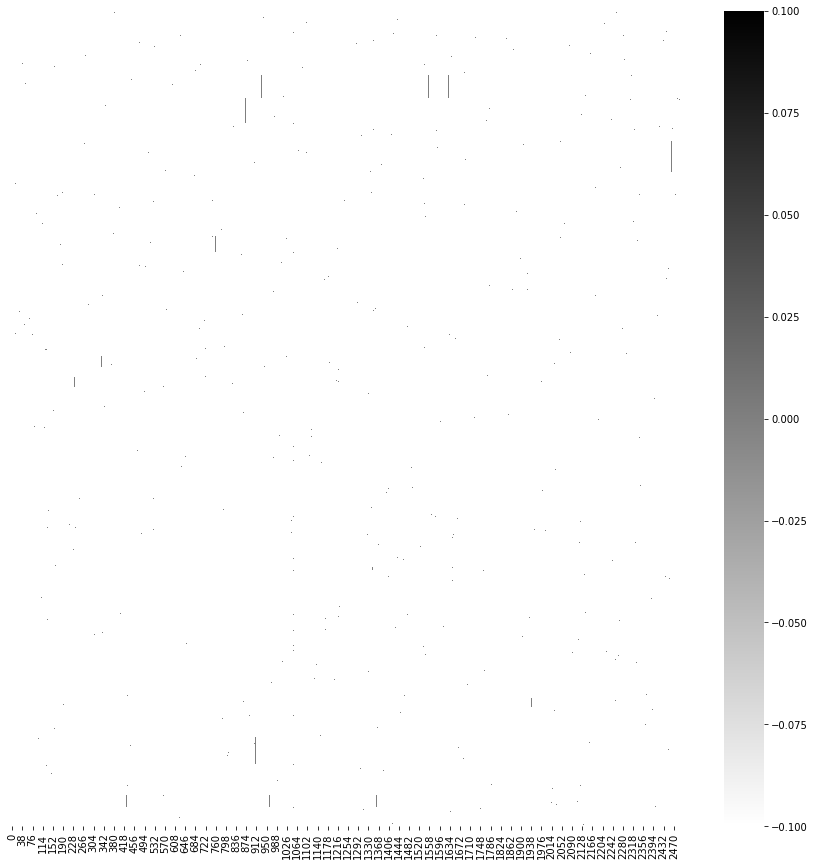

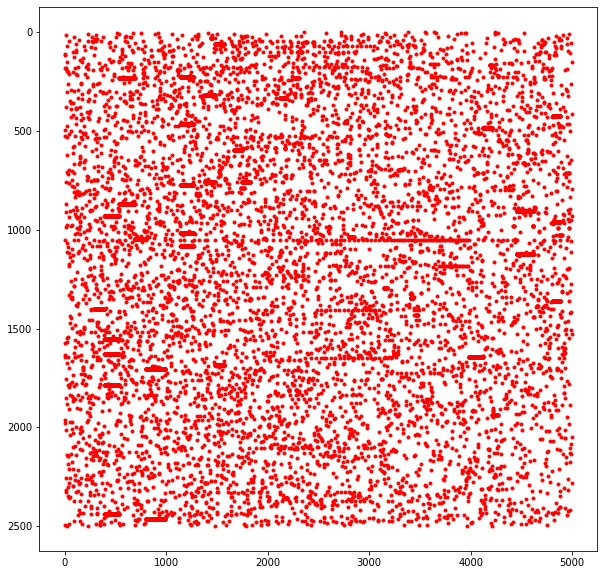

In [20]:
thr = 0.005
matrix[matrix>thr] = np.inf
print_matrix_info(matrix)

matrix[matrix>matrix.mean()] = np.inf
print_preference_matrix(matrix)

In [21]:
print(model_top_ten(matrix))

[2462 1703 1124  908  231  871 1554 1629  931 2438]


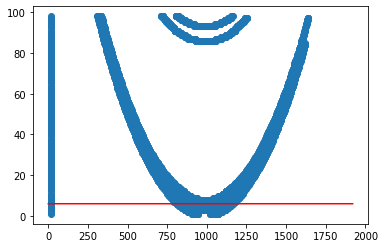

In [26]:
print_model_with_pts(models[231], pts)

In [27]:
matrix.shape

(5000, 2500)

In [51]:
from scipy.spatial.distance import jaccard, pdist, squareform

def get_distance_matrix(matrix, thr):
    truncated = np.zeros(shape=matrix.shape,dtype=np.int32)
    truncated[matrix>=thr] = 100
    truncated[matrix<thr] = 1
    truncated[truncated==100] = 0
    
    # calculate distance between rows
    distance_matrix = pdist(truncated, metric='jaccard')
    distance_matrix = squareform(distance_matrix)
    return distance_matrix

def print_distance_matrix(matrix):
    
    # mask because it is simmetrical
    corr = np.corrcoef(np.random.randn(matrix.shape[0], 200))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    
    
    fig, ax = plt.subplots(figsize=(15,15))
    sn.heatmap(matrix, cmap="binary", mask=mask, vmax=1, vmin=0, xticklabels=False, yticklabels=False)

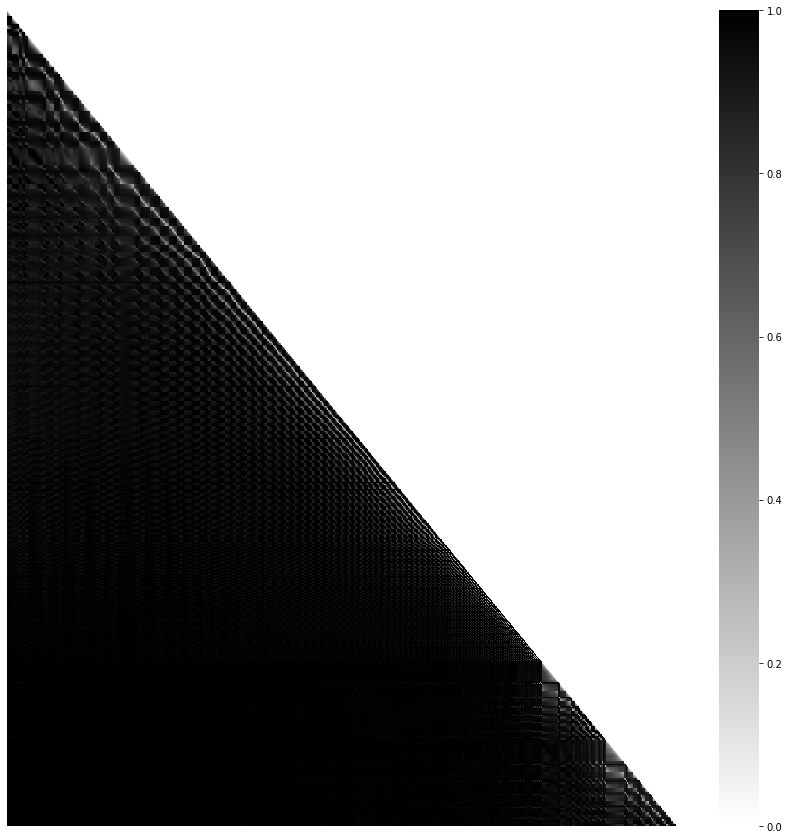

In [123]:
distance_matrix = get_distance_matrix(matrix, 2)
print_distance_matrix(distance_matrix)

In [55]:
print_matrix_info(distance_matrix)

mean:	 0.995424160863583
min:	 0.0
max:	 1.0
num of total:	 5000
num of dropped:	 0
num of minimum:	 6128
num of maximum:	 24738842
num of < average:	 261158
num of > average:	 24738842


In [58]:
from sklearn.cluster import DBSCAN

def get_clusters_from_distance(distance_matrix, eps):

    db = DBSCAN(eps=eps, metric='precomputed').fit(distance_matrix)
    pts_clusters = db.fit_predict(distance_matrix)
    clusters_label = np.unique(pts_clusters)
    
    clusters = {}
    for l in clusters_label:
        clusters.update({l: np.where(pts_clusters == l)[0]})

    return clusters, clusters_label, pts_clusters

def print_cluster(cluster_pts, pts, label, color="b"):
    coords = np.take(pts, cluster_pts, axis=0)
    plt.figure(figsize=(10, 10))
    plt.xlim(0, 1920)
    plt.ylim(420, 0)
    plt.scatter(coords[:, 0], coords[:, 1], 1, c=color)
    plt.title('Cluster {}'.format(label))


In [126]:
clusters, clusters_label, pts_clusters = get_clusters_from_distance(distance_matrix, 0.5)

[-1  0  1  2]


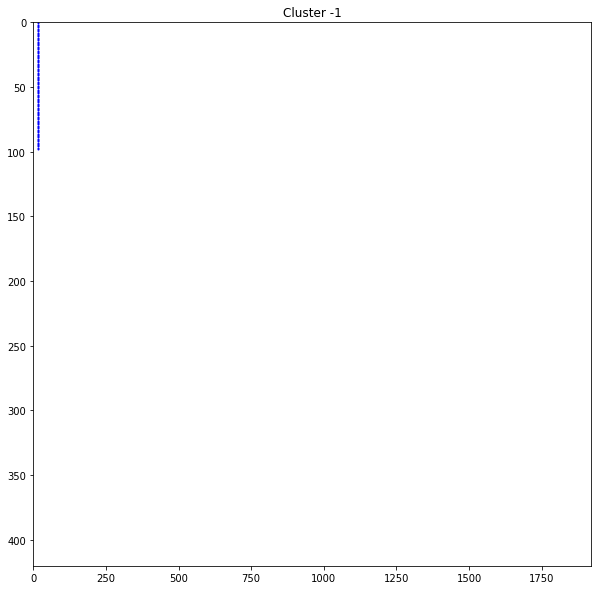

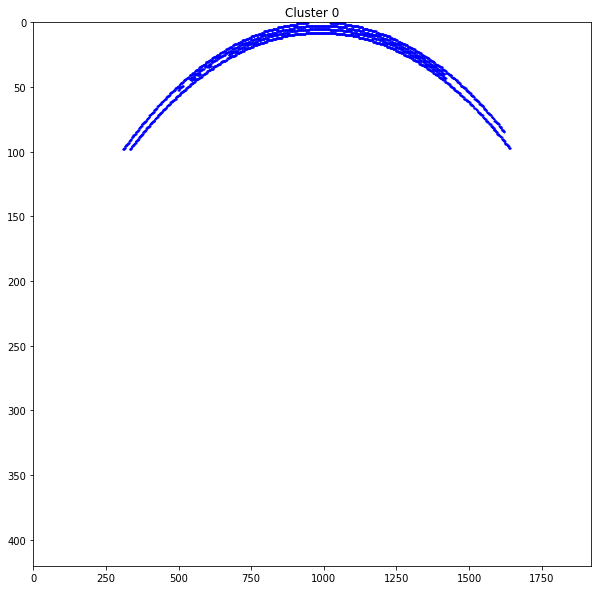

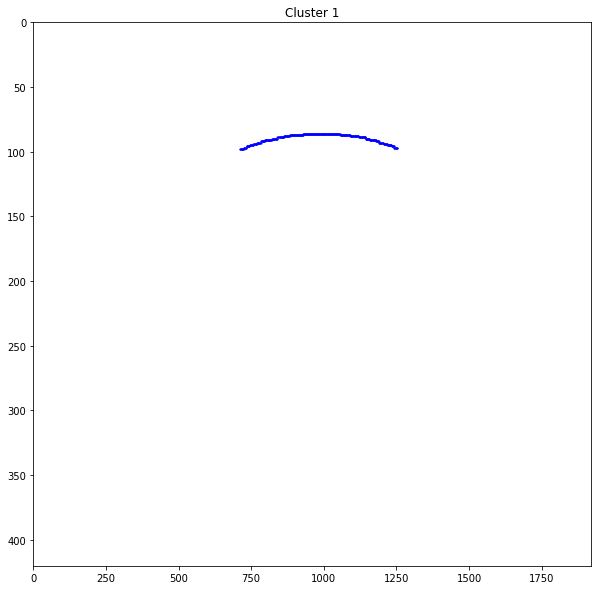

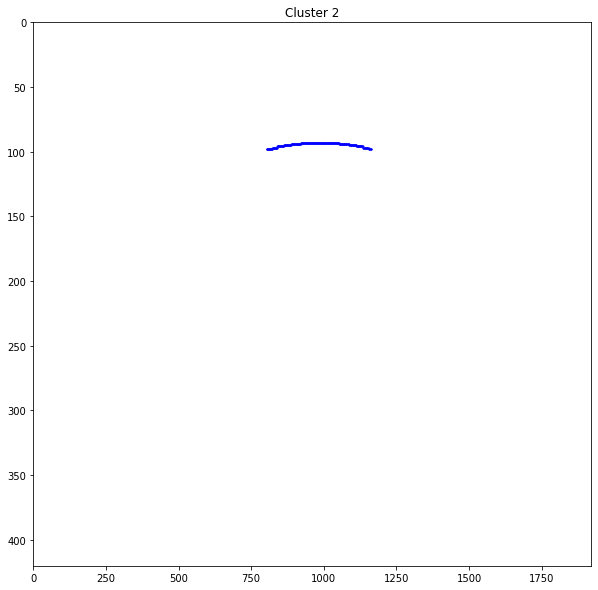

In [135]:
print (clusters_label)
for l in clusters_label:
    print_cluster(clusters[l], pts, '{}'.format(l))

num of points: (5000, 2)


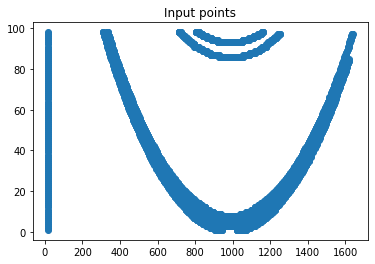

In [137]:
print_points(pts)

In [35]:
from scipy.spatial.distance import jaccard, pdist, squareform

a = np.array([1, 0, 1, 1, 1, 0])
b = np.array([[1, 0, 1, 1, 1, 0], [1, 1, 1, 0, 0, 0], [1, 1, 1, 0, 0, 0], [1, 1, 1, 0, 0, 0]])
print(b.shape)

print(squareform(pdist(b, metric='jaccard')))
matrix = np.zeros(shape=(4, 4))
for i in range(4):
    for j in range(4):
        matrix[i, j] = jaccard(b[i], b[j])

print(matrix)

(4, 6)
[[0.  0.6 0.6 0.6]
 [0.6 0.  0.  0. ]
 [0.6 0.  0.  0. ]
 [0.6 0.  0.  0. ]]
[[0.  0.6 0.6 0.6]
 [0.6 0.  0.  0. ]
 [0.6 0.  0.  0. ]
 [0.6 0.  0.  0. ]]


0.0


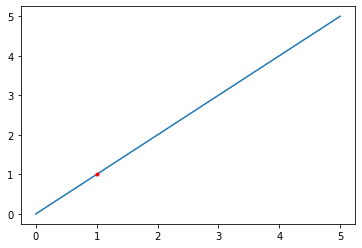

In [61]:
m = 1
q = 0

x = np.linspace(0, 5, 5) # roi dimension
y = m * x + q

a = -m
b = 1
c = -q

p = (1, 1)
d = np.abs(a * p[0] + b * p[1] + c)/ np.sqrt(a**2 + b**2)

print(d)
plt.plot(x, y)
plt.plot(p[0], p[1], 'r.',)

In [66]:
p = np.array([[1, 0], [2, 1], [3, 2]])
x = p[:, 0]
y = p[:, 1]

In [72]:
np.multiply(x, 5) + np.multiply(y, 1) + np.repeat(0, len(x))

array([ 5, 11, 17])

In [74]:
d = np.abs(np.multiply(a, x) + np.multiply(b, y) + np.repeat(c, len(x))) / np.sqrt(a**2 + b**2)

In [84]:
roi.shape

(420, 1920)

In [131]:
np.sum((matrix == np.inf).astype=np.int32)

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (2889474546.py, line 1)

In [171]:
matrix[:, 2]

array([inf, inf, inf, ..., inf, inf, inf])

In [186]:
print(model_top_ten(matrix))

[2461  183  615 1917 2195  668 2004 1419  755 1454]


In [ ]:
def apply_dft(img, keep = 0.1, **kwargs):
    
    dft = np.fft.fft2(img)
    dft_sort = np.sort(np.abs(dft.reshape(-1)))
    
    thresh = dft_sort[int(np.floor(1-keep) * len(dft_sort))]
    ind = np.abs(dft) > thresh
    atLow = dft * ind
    imgLow = np.fft.ifft2(atLow).real
    
    return imgLow

In [ ]:
for keep in (0.1, 0.05, 0.01, 0.002): 
    new_roi = apply_dft(roi, keep=keep)
    plt.figure(figsize=(20, 20))
    plt.imshow(new_roi)
    new_row, new_col = new_roi.nonzero()
    new_pts = np.column_stack((new_col, new_row)) # this are the points
    print("{} keep] {}".format(keep, new_pts.shape))